In [5]:
import pandas as pd
import netCDF4 as nc4
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt

List the deployments that have been manually labeled

In [6]:
box_dir = "/Users/frank/Box/Research/1 In progress/Gas exchange/Breathing ethogram/"
available_data = pd.read_excel(box_dir + "BreathingVideo.xlsx", 
                               engine="openpyxl",
                               sheet_name="Overview",
                               index_col=0)
available_data = available_data[available_data.index.str.contains('[A-z]{2}[0-9]{6}') == True]
available_data[["aligned", "prh_nc"]] = available_data[["aligned", "prh_nc"]].astype(bool)
available_data = available_data.query("aligned & prh_nc")
available_data

,species,n_breaths,start,stop,total_time,notes,aligned,prh_nc
id,,,,,,,,
bb180125-30,bb,64.0,(03),(05),01:15:16,After (05) camera slips to ventral position,True,True
bb190228-55b,bb,387.0,(02),NaN,04:54:30,"Interesting interactions with the boat, includ...",True,True
bb190309-52,bb,115.0,(38-44),(89),01:27:57,Can't count individual breaths while ice is in...,True,True
be180423-42,be,202.0,(02),(23-25),03:26:49,"Tag slips to left flank, but breaths still vis...",True,True
bp180526-42,bp,145.0,(02),(13),04:48:33,All videos usable!,True,True
bp180526-44,bp,140.0,(01),(12-13),05:00:20,Slips to armpit starting after (13). A few vid...,True,True
bs190322-47,bs,92.0,(01),(12),02:16:52,Mix of skim feeding and lunge feeding. Large t...,True,True
bs190322-49,bs,67.0,(08),(10),00:43:43,Surface skim feeding that looks like breathing...,True,True
bw180828-49,bw,361.0,(06-08),(64),03:16:59,Entire video usable!,True,True


Pick a deployment and read the PRH

In [36]:
export_id = "bb180125-30"
nc_path = glob("/Volumes/GoogleDrive/Shared drives/CATS/tag_data/{}*/*.nc".format(export_id))
print(nc_path)
prh_nc = nc4.Dataset(nc_path[0])

['/Volumes/GoogleDrive/Shared drives/CATS/tag_data/bb180125-30 (Antarctic)/bb180125-30_prh10.nc']


In [37]:
whale_tz = "Etc/GMT%+i" % -prh_nc.dephist_device_tzone
dt = pd.to_datetime(np.array(prh_nc["DN"]) - 719529, unit="D", utc=True).tz_convert(whale_tz)
depth, pitch, roll = [np.array(prh_nc[var]) for var in ["P", "pitch", "roll"]]
jerk = np.sum(np.diff(np.array(prh_nc["Aw"]), append=np.nan) ** 2, axis=0)
prh_data = pd.DataFrame(index=dt, data={"depth": depth, "pitch": pitch, "roll": roll, "jerk": jerk})
prh_data.head()

,depth,pitch,roll,jerk
2018-01-25 14:49:38.000006400-03:00,-0.886556,0.208026,-0.141330,0.030775
2018-01-25 14:49:38.099971199-03:00,-0.856051,0.203963,-0.151442,0.020681
2018-01-25 14:49:38.200022399-03:00,-0.817052,0.207749,-0.137199,0.053993
2018-01-25 14:49:38.299987200-03:00,-0.811307,0.204368,-0.113915,0.032502
2018-01-25 14:49:38.400038400-03:00,-0.864779,0.195388,-0.122551,0.009368


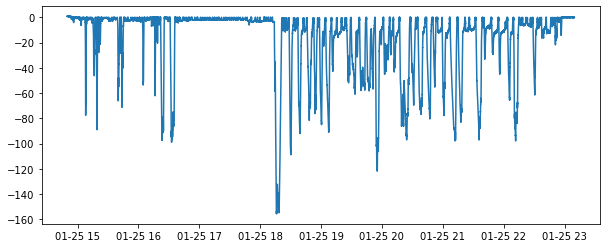

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(prh_data.index, -prh_data["depth"])
plt.show()

Match video coverage to PRH data

In [39]:
video_coverage = pd.read_excel(box_dir + "BreathingVideo.xlsx", 
                               engine="openpyxl",
                               sheet_name="Time alignment",
                               index_col=0,
                               converters = {"boristime1": str, "boristime2": str}).loc[export_id]
for col in ["camtime1", "camtime2"]:
    video_coverage[col] = video_coverage[col].dt.tz_localize(whale_tz)
for col in ["boristime1", "boristime2"]:
    video_coverage[col] = pd.to_timedelta(video_coverage[col]).dt.total_seconds()

video_coverage.head()

,media,boristime1,camtime1,boristime2,camtime2,error_s,error_ratio,Unnamed: 8
id,,,,,,,,
bb180125-30,(03),3.336,2018-01-25 16:00:18.500000-03:00,1771.131,2018-01-25 16:29:47.500000-03:00,1.205,0.000682,NaN
bb180125-30,(04),1792.984,2018-01-25 16:30:42.600000-03:00,3565.548,2018-01-25 17:00:16.100000-03:00,0.936,0.000528,NaN
bb180125-30,(05),3570.604,2018-01-25 18:00:19.200000-03:00,4508.724,2018-01-25 18:15:57.700000-03:00,0.380,0.000405,NaN


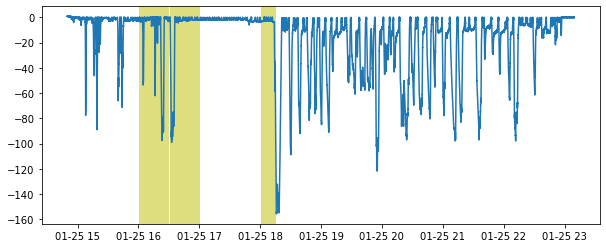

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(prh_data.index, -prh_data["depth"])
for row in range(len(video_coverage)):
    plt.axvspan(video_coverage["camtime1"].iloc[row], 
                video_coverage["camtime2"].iloc[row],
                color="y", alpha = 0.5, lw=0)
plt.show()

Pick out a sample and highlight labeled breaths

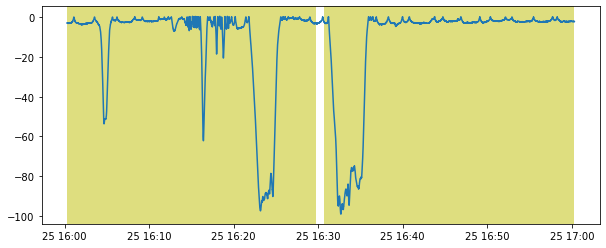

In [44]:
sample_start, sample_end = "2018-01-25 16:00:18", "2018-01-25 17:00:16"
sample_data = prh_data.loc[sample_start:sample_end]
plt.figure(figsize=(10, 4))
plt.plot(sample_data.index, -sample_data["depth"])
is_overlap = np.logical_and(video_coverage["camtime1"] < sample_end, 
                            video_coverage["camtime2"] > sample_start)
overlap_vids = video_coverage[is_overlap]
for row in range(len(overlap_vids)):
    plt.axvspan(overlap_vids["camtime1"].iloc[row], 
                overlap_vids["camtime2"].iloc[row],
                facecolor="y", alpha=0.5, lw=0)
plt.show()

In [45]:
def boristime_to_camtime(boristime):
        def interleave(l1, l2):
            result = l1 + l2
            result[::2] = l1
            result[1::2] = l2
            return result

        xs = interleave(list(video_coverage["boristime1"]), list(video_coverage["boristime2"]))
        ys = interleave(list(video_coverage["camtime1"]), list(video_coverage["camtime2"]))
        min_y = np.min(ys)
        ys_float = pd.Series(np.subtract(ys, min_y)).dt.total_seconds()
        camtime_float = np.interp(boristime, xs, ys_float)
        return min_y + pd.to_timedelta(camtime_float, unit="s")
    
breath_data = pd.read_csv(box_dir + "breaths.csv", 
                          index_col=0, 
                          usecols=[0, 3, 11, 12]).loc[export_id]
breath_data["breath_start"] = boristime_to_camtime(breath_data["Start (s)"])
breath_data["breath_end"] = boristime_to_camtime(breath_data["Stop (s)"])

breaths = breath_data["breath_start"] + (breath_data["breath_start"] - breath_data["breath_end"]) / 2
breaths

Observation id
bb180125-30   2018-01-25 16:01:04.679956670-03:00
bb180125-30   2018-01-25 16:03:29.675223938-03:00
bb180125-30   2018-01-25 16:05:36.934910156-03:00
bb180125-30   2018-01-25 16:06:09.644691269-03:00
bb180125-30   2018-01-25 16:08:15.549954887-03:00
                              ...                
bb180125-30   2018-01-25 18:03:51.866108814-03:00
bb180125-30   2018-01-25 18:05:48.466320407-03:00
bb180125-30   2018-01-25 18:07:51.125985482-03:00
bb180125-30   2018-01-25 18:10:01.231665458-03:00
bb180125-30   2018-01-25 18:11:57.153102216-03:00
Length: 64, dtype: datetime64[ns, Etc/GMT+3]

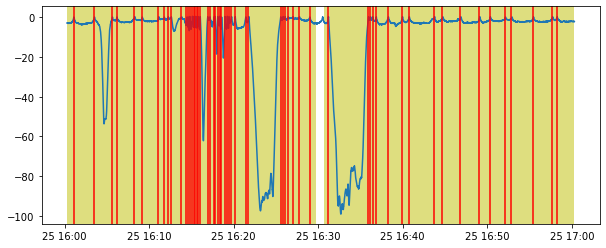

In [46]:
overlap_breaths = breaths[np.logical_and(breaths > sample_start, breaths < sample_end)]
plt.figure(figsize=(10, 4))
plt.plot(sample_data.index, -sample_data["depth"])
is_overlap = np.logical_and(video_coverage["camtime1"] < sample_end, 
                            video_coverage["camtime2"] > sample_start)
overlap_vids = video_coverage[is_overlap]
for row in range(len(overlap_vids)):
    plt.axvspan(overlap_vids["camtime1"].iloc[row], 
                overlap_vids["camtime2"].iloc[row],
                facecolor="y", alpha=0.5, lw=0)
for i in range(len(overlap_breaths)):
    plt.axvline(overlap_breaths[i], color="r")
plt.show()

Put it all in a couple functions

In [23]:
def load_data(export_id):
    # PRH data
    nc_path = glob("/Volumes/COPYCATSdat/CATS/tag_data/prh/{}*nc".format(export_id))
    assert(len(nc_path) == 1)
    prh_nc = nc4.Dataset(nc_path[0])
    whale_tz = "Etc/GMT%+i" % -prh_nc.dephist_device_tzone
    dt = pd.to_datetime(np.array(prh_nc["DN"]) - 719529, unit="D", utc=True).tz_convert(whale_tz)
    depth, pitch, roll = [np.array(prh_nc[var]) for var in ["P", "pitch", "roll"]]
    jerk = np.sum(np.diff(np.array(prh_nc["Aw"]), append=np.nan) ** 2, axis=0)
    prh_data = pd.DataFrame(index=dt, data={"depth": depth, "pitch": pitch, "roll": roll, "jerk": jerk})
    
    # Video coverage data
    video_coverage = pd.read_excel(box_dir + "BreathingVideo.xlsx", 
                                   engine="openpyxl",
                                   sheet_name="Time alignment",
                                   index_col=0,
                                   converters = {"boristime1": str, "boristime2": str}).loc[export_id]
    for col in ["camtime1", "camtime2"]:
        video_coverage[col] = video_coverage[col].dt.tz_localize(whale_tz)
    for col in ["boristime1", "boristime2"]:
        video_coverage[col] = pd.to_timedelta(video_coverage[col]).dt.total_seconds()
    video_coverage2 = video_coverage.copy()[["camtime1", "camtime2"]]
    video_coverage2.index = 1 + np.arange(len(video_coverage2))
    video_coverage2.columns = ["vid_start", "vid_stop"]
        
    # Breath data
    def boristime_to_camtime(boristime):
        def interleave(l1, l2):
            result = l1 + l2
            result[::2] = l1
            result[1::2] = l2
            return result

        xs = interleave(list(video_coverage["boristime1"]), list(video_coverage["boristime2"]))
        ys = interleave(list(video_coverage["camtime1"]), list(video_coverage["camtime2"]))
        min_y = np.min(ys)
        ys_float = pd.Series(np.subtract(ys, min_y)).dt.total_seconds()
        camtime_float = np.interp(boristime, xs, ys_float)
        return min_y + pd.to_timedelta(camtime_float, unit="s")
    breath_data = pd.read_csv(box_dir + "breaths.csv", 
                              index_col=0, 
                              usecols=[0, 3, 11, 12]).loc[export_id]
    breath_data["breath_start"] = boristime_to_camtime(breath_data["Start (s)"])
    breath_data["breath_end"] = boristime_to_camtime(breath_data["Stop (s)"])

    breaths = breath_data["breath_start"] + (breath_data["breath_start"] - breath_data["breath_end"]) / 2
    breaths = pd.Index(breaths)
    
    # Plot it
    plt.figure(figsize=(10, 4))
    plt.plot(prh_data.index, -prh_data["depth"])
    for row in range(len(video_coverage)):
        plt.axvspan(video_coverage["camtime1"].iloc[row], 
                    video_coverage["camtime2"].iloc[row],
                    color="y", alpha = 0.5, lw=0)
    for i in range(len(breaths)):
        plt.axvline(breaths[i], color="r")
    plt.show()
    
    return prh_data, video_coverage2, breaths

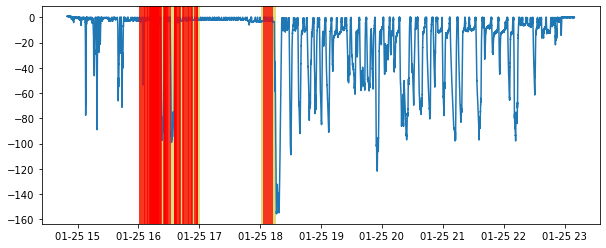

In [29]:
all_data = load_data("bb180125-30")

In [30]:
from ipdb import set_trace

def diff_seconds(values, array):
    left_idx = np.searchsorted(array, values, side="left")
    right_idx = left_idx + 1
    right_idx[right_idx == len(array)] = len(array)- 1
    left_diff = np.abs((values - array[left_idx]).total_seconds())
    right_diff = np.abs((values - array[right_idx]).total_seconds())
    return np.minimum(left_diff, right_diff)

def stitch_data(all_data):
    prh_data, video_coverage, breaths = all_data
    
    # Stitch prh_data by video coverage
    prh_data["covered"] = False
    for vid_start, vid_stop in zip(video_coverage["vid_start"], video_coverage["vid_stop"]):
        start_loc = prh_data.index.get_loc(vid_start, method="nearest")
        stop_loc = prh_data.index.get_loc(vid_stop, method="nearest")
        prh_data.iloc[start_loc:stop_loc, prh_data.columns.get_loc("covered")] = True
    stitched_data = prh_data[prh_data["covered"]].drop("covered", axis=1).copy()
    
    breath_diff = diff_seconds(breaths, stitched_data.index)
    assert np.all(breath_diff < 0.1), ">0.1s between breath and PRH"
    
    plt.figure(figsize=(10, 4))
    plt.plot(stitched_data.index, -stitched_data["depth"])
    for i in range(len(breaths)):
        plt.axvline(breaths[i], color="r")
    plt.show()
    
    return stitched_data, breaths

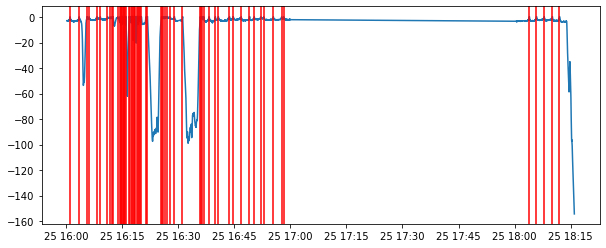

In [31]:
stitched = stitch_data(all_data)

In [33]:
def combine_deployments(exportids):
    prh_all, breaths_all = pd.DataFrame(), pd.MultiIndex.from_arrays([[], []])
    for thisid in exportids:
        stitched_data, breaths = stitch_data(load_data(thisid))
        stitched_data.index = pd.MultiIndex.from_product([[thisid], stitched_data.index])
        breaths = pd.MultiIndex.from_product([[thisid], breaths])
        prh_all = prh_all.append(stitched_data)
        breaths_all = breaths_all.union(breaths)
    return prh_all, breaths_all

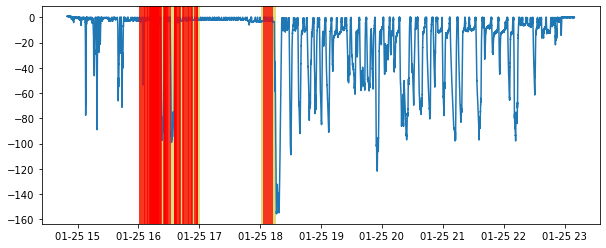

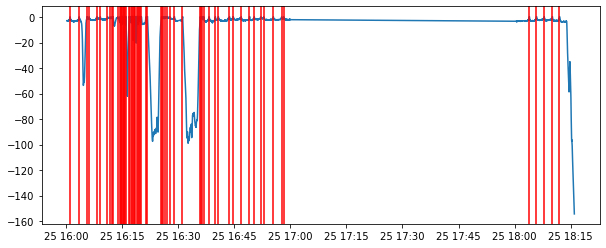

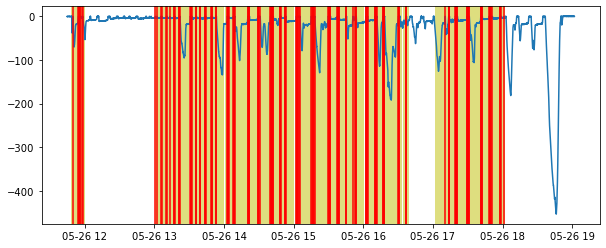

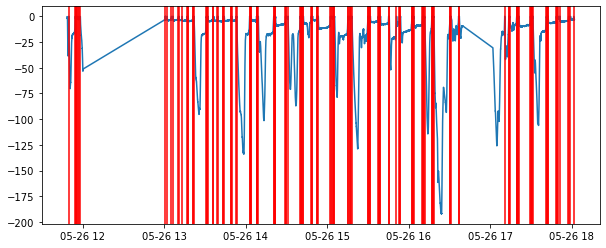

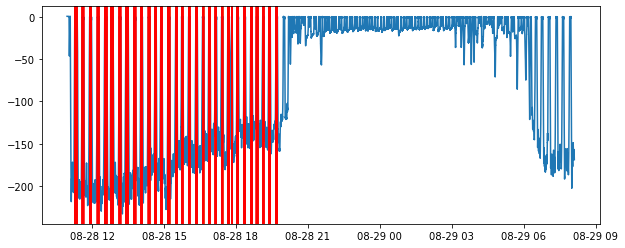

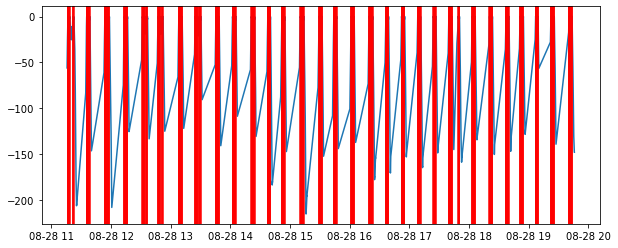

In [34]:
exportids = ["bb180125-30", "bp180526-42", "bw180828-49"]
prh_all, breaths_all = combine_deployments(exportids)

In [35]:
prh_all.to_pickle("../data/multi_prh.pkl")
pd.Series(True, index=breaths_all, name="event").to_pickle("../data/multi_breaths.pkl")